In [1]:
import numpy as np
import torch
from torchvision import models
from torch.autograd import Variable
import scipy.io
import json
import os
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import copy
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from skimage.transform import resize

### image loading

In [2]:
# functions for image loading

pic_filepath = "imagenet_sample"
jsonfilepath=pic_filepath+'/imagenet_label_index.json'
matfilepath=pic_filepath+'/ILSVRC2012_meta.mat'
data_filepath=pic_filepath + "/images"

# modeloutput_id_wnid_class
def get_model_output_id_wnid_class_dict(jsonfilepath=jsonfilepath):
    '''
    get the dict of model output ID, WNID and class name
    from the given json file
    format: {"Model Ouput ID": ["WNID", "Class"]}
    '''
    with open(jsonfilepath, 'r') as f:
        id_dict = json.load(f)
    
    return id_dict

# imagenet_id_wnid_class
def get_imagenet_id_wnid_class_dict(matfilepath=matfilepath):
    '''
    get the dict of ImageNet ID, WNID and class name
    from the given mat file
    format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
    '''
    meta=scipy.io.loadmat(matfilepath)['synsets']
    length=len(meta)
    id_dict={str(meta[0][0][0][0][0]):[meta[0][0][1][0], meta[0][0][2][0]]}
    for i in range(1, length):
        id_dict[str(meta[i][0][0][0][0])]=[meta[i][0][1][0], meta[i][0][2][0]]
        
    return id_dict

def map_model_id_to_imagenet_id(imagenet_id, modeloutput_id):
    '''
    return a dict mapping modeloutput id to imagenet id
    '''
    map_dict={}
    for imagenet_id_key in imagenet_id:
        for modeloutput_id_key in modeloutput_id:
            if modeloutput_id[modeloutput_id_key][0]==imagenet_id[imagenet_id_key][0]:
                map_dict[modeloutput_id_key]=imagenet_id_key
                break
    return map_dict

def map_imagenet_id_to_model_id(imagenet_id, modeloutput_id):
    '''
    return a dict mapping imagenet id to modeloutput id
    '''
    map_dict={}
    for imagenet_id_key in imagenet_id:
        for modeloutput_id_key in modeloutput_id:
            if modeloutput_id[modeloutput_id_key][0]==imagenet_id[imagenet_id_key][0]:
                map_dict[imagenet_id_key]=modeloutput_id_key
                break
    return map_dict

def get_img_names_and_labels_from_imagenet_sample(data_filepath=data_filepath):
    img_files=os.listdir(data_filepath)
    img_files.sort()
    
    labels = []
    for idx, file in enumerate(img_files):
        labels.append(int(file.split("_")[0]))
    
    print("There are "+str(len(img_files))+" imgs, and "+str(len(np.unique(np.array(labels))))+" classes.")
    
    return img_files, labels

def load_img_from_imagenet_sample_by_index(index, imagenet_labels=None,
                                           data_filepath=data_filepath):
    '''
    INPUT:
    index
    imagenet_labels: a dict, len=1000, {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
    data_filepath:
    (name format of imgs: [ImageNet_ID]_[WNID]_[N].JPEG, N: 0~4, e.g. "141_n02104029_3.JPEG" means ImageNet ID: 141, WNID: n02104029,
    3nd pic of this class, and its class is 'kuvasz'.)
    
    OUTPUT:
    the img file
    '''
    img_files, labels = get_img_names_and_labels_from_imagenet_sample(data_filepath)
    
    load_img = Image.open(data_filepath+"/"+img_files[index]).convert('RGB')
    
    if imagenet_labels is not None:
        print("load img "+data_filepath+"/"+img_files[index]+\
              "\nImageNet ID: "+str(labels[index])+\
              "\nWNID and class: "+str(imagenet_labels[str(labels[index])]))
    else:
        print("load img "+data_filepath+"/"+img_files[index]+\
              "\nImageNet ID: "+str(labels[index]))
    
    return load_img, index, labels[index]

def load_img_from_imagenet_sample_by_class(imagenet_id, imagenet_labels=None,
                                           data_filepath=data_filepath):
    '''
    INPUT:
    imagenet_id: 1~1000, indicating which class to load, we'll randomly choice one img in the class
    imagenet_labels: a dict, len=1000, {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
    data_filepath:
    (name format of imgs: [ImageNet_ID]_[WNID]_[N].JPEG, N: 0~4, e.g. "141_n02104029_3.JPEG" means ImageNet ID: 141, WNID: n02104029,
    3nd pic of this class, and its class is 'kuvasz'.)
    
    OUTPUT:
    the img file
    '''
    img_files, labels = get_img_names_and_labels_from_imagenet_sample(data_filepath)
    
    idxs=np.where(np.array(labels)==imagenet_id)[0]
    chosen_idx=int(np.random.choice(idxs, 1))
    
    load_img = Image.open(data_filepath+"/"+img_files[chosen_idx]).convert('RGB')
    
    if imagenet_labels is not None:
        print("load img "+data_filepath+"/"+img_files[chosen_idx]+\
              "\nImageNet ID: "+str(labels[chosen_idx])+\
              "\nWNID and class: "+str(imagenet_labels[str(labels[chosen_idx])]))
    else:
        print("load img "+data_filepath+"/"+img_files[chosen_idx]+\
              "\nImageNet ID: "+str(labels[chosen_idx]))
    
    return load_img, chosen_idx, imagenet_id

In [3]:
# get the dict of ImageNet ID, WNID and class name
# format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
imagenet_id_label=get_imagenet_id_wnid_class_dict()

# get the dict of model output ID, WNID and class name
# format: {"Model Ouput ID": ["WNID", "Class"]}
modeloutput_id_label=get_model_output_id_wnid_class_dict()

# get dict map model output ID to ImageNet ID
map_dict_model2imagenet=map_model_id_to_imagenet_id(imagenet_id_label, modeloutput_id_label)

# get ImageNet ID to dict map model output ID
map_dict_imagenet2model=map_imagenet_id_to_model_id(imagenet_id_label, modeloutput_id_label)

In [4]:
imagenet_id_label

{'1': ['n02119789', 'kit fox, Vulpes macrotis'],
 '2': ['n02100735', 'English setter'],
 '3': ['n02110185', 'Siberian husky'],
 '4': ['n02096294', 'Australian terrier'],
 '5': ['n02102040', 'English springer, English springer spaniel'],
 '6': ['n02066245',
  'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus'],
 '7': ['n02509815',
  'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens'],
 '8': ['n02124075', 'Egyptian cat'],
 '9': ['n02417914', 'ibex, Capra ibex'],
 '10': ['n02123394', 'Persian cat'],
 '11': ['n02125311',
  'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'],
 '12': ['n02423022', 'gazelle'],
 '13': ['n02346627', 'porcupine, hedgehog'],
 '14': ['n02077923', 'sea lion'],
 '15': ['n02110063', 'malamute, malemute, Alaskan malamute'],
 '16': ['n02447366', 'badger'],
 '17': ['n02109047', 'Great Dane'],
 '18': ['n02089867', 'Walker hound, Walker foxhound'],
 '19': ['n02102177', 'Welsh springer spaniel'],
 '2

There are 10 imgs, and 2 classes.
load img imagenet_sample/images/80_n02391049_4.JPEG
ImageNet ID: 80
WNID and class: ['n02391049', 'zebra']
Pic ID is 9
imagenet ID is 80
Model class ID is 340


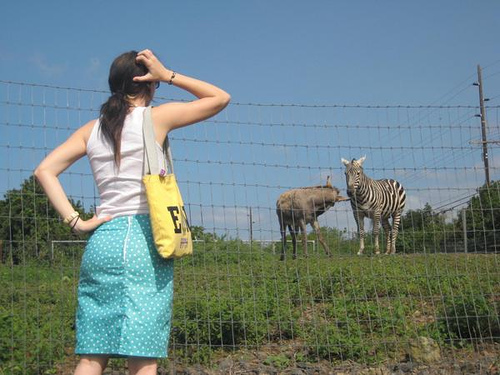

In [5]:
# input an ImageNet ID, 1~1000, indicating which class to load, we'll randomly choice one img in the class
img, pix_id, imagenet_id = load_img_from_imagenet_sample_by_class(80, imagenet_labels=imagenet_id_label)
model_id = int(map_dict_imagenet2model[str(imagenet_id)])
print("Pic ID is "+str(pix_id))
print("imagenet ID is "+str(imagenet_id))
print("Model class ID is "+str(model_id))
img

There are 10 imgs, and 2 classes.
load img imagenet_sample/images/80_n02391049_0.JPEG
ImageNet ID: 80
WNID and class: ['n02391049', 'zebra']
Pic ID is 5
imagenet ID is 80
Model class ID is 340


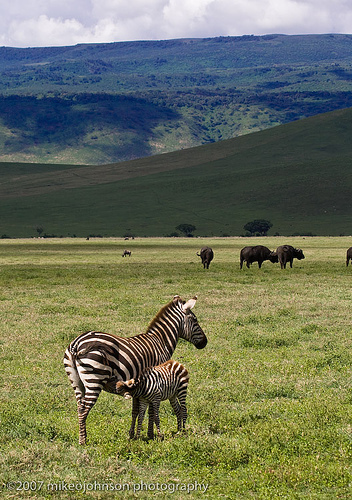

In [6]:
# input an index indicating which image file to load
img2, pix_id2, imagenet_id2 = load_img_from_imagenet_sample_by_index(5, imagenet_labels=imagenet_id_label)
model_id2 = int(map_dict_imagenet2model[str(imagenet_id2)])
print("Pic ID is "+str(pix_id2))
print("imagenet ID is "+str(imagenet_id2))
print("Model class ID is "+str(model_id2))
img2

### function for image preprocessing

In [7]:
# process an ImageNet raw image to input it into a CNN
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")
            
    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)
        
    im_as_arr = np.float32(pil_im)
    
    im_resize = np.array(im_as_arr, dtype = np.int)
    
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    
    return im_as_var, im_resize

### load pretrained model

In [8]:
pretrained_model = models.vgg19(pretrained=True)

print("model arch:")
print(pretrained_model)
for name, module in pretrained_model.named_modules():
    print(name)
#print(list(pretrained_model._modules.items()))

model arch:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=

### get activation and gradient of a certain layer

In [9]:
target_layers = ["features.25"]

In [10]:
activation = []
gradient = []
def forward_hook(model, ten_in, ten_out):
    global activation
    activation.append(copy.deepcopy(ten_out.cpu().detach().numpy()))

def backward_hook(model, grad_in, grad_out):
    global gradient
    gradient.append(copy.deepcopy(grad_out[0].cpu().detach().numpy()))

# which layer
for name, module in pretrained_model.named_modules():
    if name in target_layers:
        print("target layer: "+str(name))
        module.register_forward_hook(forward_hook)
        module.register_backward_hook(backward_hook)

target layer: features.25


In [11]:
def get_layer_activation_gradient_of_an_image(img, modeloutput_id_label=None, model_id=None, get_gradient=False):
    global activation
    global gradient
    activation = []
    gradient = []
    input_img_tensor, input_img_arr = preprocess_image(img)
    if get_gradient:
        model_output=pretrained_model(input_img_tensor)
    else:
        with torch.no_grad():
            model_output=pretrained_model(input_img_tensor)
    
    predicted_model_id = torch.argmax(model_output).detach().cpu().numpy()
    print("predicted model id is "+str(predicted_model_id))
    
    if modeloutput_id_label is not None:
        print("predicted class is "+str(modeloutput_id_label[str(predicted_model_id)]))
    
    if model_id is not None and modeloutput_id_label is not None:
        print("true model id is "+str(model_id))
        print("true imagenet id is "+str(map_dict_model2imagenet[str(model_id)]))
        print("true class is "+str(modeloutput_id_label[str(model_id)]))
    
    if get_gradient:
        if model_id is not None and modeloutput_id_label is not None:
            pretrained_model.zero_grad()
            one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
            one_hot_output[0][model_id] = 1
            model_output.backward(gradient=one_hot_output)
        else:
            pretrained_model.zero_grad()
            one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
            one_hot_output[0][predicted_model_id] = 1
            model_output.backward(gradient=one_hot_output)
    
    return input_img_tensor, input_img_arr

In [12]:
# note that here we use img2
input_img_tensor, input_img_arr = get_layer_activation_gradient_of_an_image(img2, modeloutput_id_label, model_id2, get_gradient=True)

C:\Users\anton\AppData\Local\Temp/ipykernel_16052/3766087063.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_resize = np.array(im_as_arr, dtype = np.int)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when

predicted model id is 340
predicted class is ['n02391049', 'zebra']
true model id is 340
true imagenet id is 80
true class is ['n02391049', 'zebra']


In [13]:
activation_squeezed = np.squeeze(activation[0])
gradient_squeezed = np.squeeze(gradient[0])
print('Flat activation size: ', activation_squeezed.flatten().shape[0])
print('Flat gradient size: ', gradient_squeezed.flatten().shape[0])

Flat activation size:  401408
Flat gradient size:  401408


### get Spatial Activation Concept Vector (SACV)
#### Please download the texture dataset: https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html

In [14]:
# the name of the texture dataset is dtd
path = 'dtd/images/'

patterns = os.listdir(path)
   
tgt_patterns = ['striped']
rnd_patterns = patterns
for patt in tgt_patterns:
    if patt in rnd_patterns:
        rnd_patterns.remove(patt)

In [15]:
### concept set
concept_act_s = []
concept_lbl_s = []

number_of_concept_pic = 0

for patt in tgt_patterns:
    for concept_files in os.listdir(path.format(patt)+patt):
        number_of_concept_pic +=1
        
        concept_img_path = path.format(patt)+patt+'/'+concept_files
        print(concept_img_path)
        
        concept_img = Image.open(concept_img_path).convert('RGB')
        get_layer_activation_gradient_of_an_image(concept_img, modeloutput_id_label)
        print('--------------------------------------------------')
        activation = np.squeeze(activation[0])
        activation = activation.reshape(activation.shape[0], activation.shape[1]*activation.shape[2])
        activation = activation.reshape(activation.shape[1],activation.shape[0])
        concept_act_s.append(activation)
        concept_lbl_s.append(np.zeros(activation.shape[0]))
concept_act_s = np.array(concept_act_s)
concept_act_s = concept_act_s.reshape(concept_act_s.shape[0]*concept_act_s.shape[1], concept_act_s.shape[2])
concept_lbl_s = np.array(concept_lbl_s)
concept_lbl_s = concept_lbl_s.reshape(concept_lbl_s.shape[0]*concept_lbl_s.shape[1])
activation = []
gradient = []

dtd/images/striped/striped_0001.jpg


C:\Users\anton\AppData\Local\Temp/ipykernel_16052/3766087063.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_resize = np.array(im_as_arr, dtype = np.int)


predicted model id is 506
predicted class is ['n03065424', 'coil']
--------------------------------------------------
dtd/images/striped/striped_0002.jpg
predicted model id is 340
predicted class is ['n02391049', 'zebra']
--------------------------------------------------
dtd/images/striped/striped_0003.jpg
predicted model id is 392
predicted class is ['n02606052', 'rock_beauty']
--------------------------------------------------
dtd/images/striped/striped_0004.jpg
predicted model id is 392
predicted class is ['n02606052', 'rock_beauty']
--------------------------------------------------
dtd/images/striped/striped_0005.jpg
predicted model id is 749
predicted class is ['n04033901', 'quill']
--------------------------------------------------
dtd/images/striped/striped_0006.jpg
predicted model id is 292
predicted class is ['n02129604', 'tiger']
--------------------------------------------------
dtd/images/striped/striped_0008.jpg
predicted model id is 292
predicted class is ['n02129604', 

predicted model id is 340
predicted class is ['n02391049', 'zebra']
--------------------------------------------------
dtd/images/striped/striped_0060.jpg
predicted model id is 292
predicted class is ['n02129604', 'tiger']
--------------------------------------------------
dtd/images/striped/striped_0061.jpg
predicted model id is 69
predicted class is ['n01768244', 'trilobite']
--------------------------------------------------
dtd/images/striped/striped_0062.jpg
predicted model id is 340
predicted class is ['n02391049', 'zebra']
--------------------------------------------------
dtd/images/striped/striped_0063.jpg
predicted model id is 340
predicted class is ['n02391049', 'zebra']
--------------------------------------------------
dtd/images/striped/striped_0064.jpg
predicted model id is 110
predicted class is ['n01924916', 'flatworm']
--------------------------------------------------
dtd/images/striped/striped_0065.jpg
predicted model id is 568
predicted class is ['n03404251', 'fur_

predicted model id is 991
predicted class is ['n12985857', 'coral_fungus']
--------------------------------------------------
dtd/images/striped/striped_0113.jpg
predicted model id is 597
predicted class is ['n03527444', 'holster']
--------------------------------------------------
dtd/images/striped/striped_0114.jpg
predicted model id is 340
predicted class is ['n02391049', 'zebra']
--------------------------------------------------
dtd/images/striped/striped_0115.jpg
predicted model id is 775
predicted class is ['n04136333', 'sarong']
--------------------------------------------------
dtd/images/striped/striped_0116.jpg
predicted model id is 905
predicted class is ['n04590129', 'window_shade']
--------------------------------------------------
dtd/images/striped/striped_0117.jpg
predicted model id is 824
predicted class is ['n04325704', 'stole']
--------------------------------------------------
dtd/images/striped/striped_0118.jpg
predicted model id is 842
predicted class is ['n04371

In [16]:
### random set
random_act_s = []
random_lbl_s = []


for i in range(number_of_concept_pic):

    patt = random.choice(rnd_patterns)
    rand_concept_img_path = path.format(patt)+patt+'/'+random.choice(os.listdir(path.format(patt)+patt))
    print(rand_concept_img_path)
    
    rand_concept_img = Image.open(rand_concept_img_path).convert('RGB')
    get_layer_activation_gradient_of_an_image(rand_concept_img, modeloutput_id_label)
    print('--------------------------------------------------')
    activation = np.squeeze(activation[0])
    activation = activation.reshape(activation.shape[0], activation.shape[1]*activation.shape[2])
    activation = activation.reshape(activation.shape[1],activation.shape[0])
    random_act_s.append(activation)
    random_lbl_s.append(np.ones(activation.shape[0]))
random_act_s = np.array(random_act_s)
random_act_s = random_act_s.reshape(random_act_s.shape[0]*random_act_s.shape[1], random_act_s.shape[2])
random_lbl_s = np.array(random_lbl_s)
random_lbl_s = random_lbl_s.reshape(random_lbl_s.shape[0]*random_lbl_s.shape[1])
activation = []
gradient = []

dtd/images/smeared/smeared_0055.jpg


C:\Users\anton\AppData\Local\Temp/ipykernel_16052/3766087063.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_resize = np.array(im_as_arr, dtype = np.int)


predicted model id is 694
predicted class is ['n03874293', 'paddlewheel']
--------------------------------------------------
dtd/images/perforated/perforated_0163.jpg
predicted model id is 828
predicted class is ['n04332243', 'strainer']
--------------------------------------------------
dtd/images/zigzagged/zigzagged_0077.jpg
predicted model id is 687
predicted class is ['n03854065', 'organ']
--------------------------------------------------
dtd/images/paisley/paisley_0021.jpg
predicted model id is 794
predicted class is ['n04209239', 'shower_curtain']
--------------------------------------------------
dtd/images/bumpy/bumpy_0195.jpg
predicted model id is 956
predicted class is ['n07760859', 'custard_apple']
--------------------------------------------------
dtd/images/perforated/perforated_0140.jpg
predicted model id is 794
predicted class is ['n04209239', 'shower_curtain']
--------------------------------------------------
dtd/images/crosshatched/crosshatched_0083.jpg
predicted mod

predicted model id is 310
predicted class is ['n02219486', 'ant']
--------------------------------------------------
dtd/images/crosshatched/crosshatched_0131.jpg
predicted model id is 646
predicted class is ['n03733281', 'maze']
--------------------------------------------------
dtd/images/banded/banded_0103.jpg
predicted model id is 533
predicted class is ['n03207743', 'dishrag']
--------------------------------------------------
dtd/images/perforated/perforated_0154.jpg
predicted model id is 828
predicted class is ['n04332243', 'strainer']
--------------------------------------------------
dtd/images/bubbly/bubbly_0152.jpg
predicted model id is 971
predicted class is ['n09229709', 'bubble']
--------------------------------------------------
dtd/images/honeycombed/honeycombed_0169.jpg
predicted model id is 599
predicted class is ['n03530642', 'honeycomb']
--------------------------------------------------
dtd/images/stained/stained_0123.jpg
predicted model id is 17
predicted class is

predicted model id is 844
predicted class is ['n04372370', 'switch']
--------------------------------------------------
dtd/images/wrinkled/wrinkled_0108.jpg
predicted model id is 853
predicted class is ['n04417672', 'thatch']
--------------------------------------------------
dtd/images/chequered/chequered_0173.jpg
predicted model id is 539
predicted class is ['n03223299', 'doormat']
--------------------------------------------------
dtd/images/zigzagged/zigzagged_0081.jpg
predicted model id is 721
predicted class is ['n03938244', 'pillow']
--------------------------------------------------
dtd/images/bumpy/bumpy_0145.jpg
predicted model id is 936
predicted class is ['n07714571', 'head_cabbage']
--------------------------------------------------
dtd/images/banded/banded_0067.jpg
predicted model id is 854
predicted class is ['n04418357', 'theater_curtain']
--------------------------------------------------
dtd/images/waffled/waffled_0117.jpg
predicted model id is 599
predicted class is

In [17]:
def get_sacv(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type = 'logistic'):

    X = np.vstack([concept_act_s,random_act_s])
    y = np.hstack([concept_lbl_s, random_lbl_s])
    X_tr, X_vl, y_tr, y_vl = train_test_split(X, y, shuffle= True)
    
    print('X train size: ',X_tr.shape)
    print('y train size: ',y_tr.shape)
    print('X valid size: ',X_vl.shape)
    print('y valid size: ',y_vl.shape)
    
    if clf_type == 'sgd':
        clf = linear_model.SGDClassifier(alpha=.01, max_iter = 1000)
        
    elif clf_type == 'logistic':
        clf = linear_model.LogisticRegression(max_iter = 1000)
        
    clf.fit(X_tr, y_tr)
    
    print('Training score: ',clf.score(X_tr, y_tr))
    print('Validation score: ',clf.score(X_vl, y_vl))

    sacv = clf.coef_[0]
    
    return sacv, clf


In [18]:
sacv, clf = get_sacv(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type='logistic')
print('SACV shape: ', sacv.shape)

X train size:  (141120, 512)
y train size:  (141120,)
X valid size:  (47040, 512)
y valid size:  (47040,)
Training score:  0.5288832199546485
Validation score:  0.5140518707482993
SACV shape:  (512,)


### get explanation map with SACV

Relevance of each spatial location to query concept

In [19]:
concept_map = np.sum(np.multiply(sacv.reshape(sacv.shape[0],1),
                                            activation_squeezed.reshape(activation_squeezed.shape[0],
                                                                      activation_squeezed.shape[1]*activation_squeezed.shape[2])), axis=0)
concept_map = concept_map.reshape(activation_squeezed.shape[1],
                                  activation_squeezed.shape[2])

print("max of concept map: "+str(np.max(concept_map)))

max of concept map: 5.58892351038022


Contribution of query concept to model prediction

In [ ]:
concept_map = np.sum(np.multiply(sacv.reshape(sacv.shape[0],1),
                                            gradient_squeezed.reshape(gradient_squeezed.shape[0],
                                                                      gradient_squeezed.shape[1]*gradient_squeezed.shape[2])), axis=0)
concept_map = concept_map.reshape(gradient_squeezed.shape[1],
                                  gradient_squeezed.shape[2])

print("max of concept map: "+str(np.max(concept_map)))

(-0.5, 223.5, 223.5, -0.5)

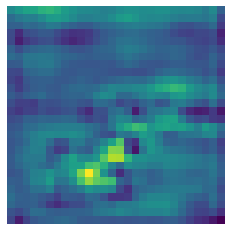

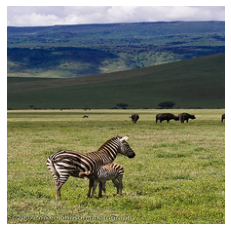

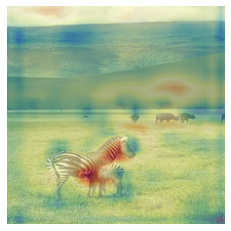

In [20]:
# draw explanation map
fig = plt.figure()
plt.imshow(concept_map)
plt.axis("off")
# plt.savefig('explanation_'+str(target_layers[0])+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

# draw explanation map
fig = plt.figure()
plt.imshow(input_img_arr)
plt.axis("off")
# plt.savefig('zebra.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(input_img_arr)
concept_map_reshaped = resize(concept_map, (input_img_arr.shape[0], input_img_arr.shape[1]))
ax.matshow(-concept_map_reshaped, cmap='Spectral', alpha=0.6)

plt.axis("off")
# plt.savefig('heatmap_'+str(target_layers[0])+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

### show receptive fields

In [ ]:
# used to show receptive fields
from func.receptive_field import receptive_field, get_rfs_from_a_mask, show_rf_in_org_img, show_some_rfs_randomly, show_some_rfs_order, get_rfs_from_a_mask_with_order

device = torch.device("cpu")
pretrained_model_features = copy.deepcopy(pretrained_model.features)
receptive_field_dict = receptive_field(pretrained_model_features.to(device), input_img_tensor[0].shape, device = "cpu")
N = target_layers[0].split(".")[-1]
rfs=get_rfs_from_a_mask_with_order(receptive_field_dict, str(N), concept_map)

In [ ]:
# show rfs which are most relevant to the chosen concept
show_some_rfs_order(input_img_arr, rfs, fig_save_name="most_relevant_"+str(target_layers[0])+".png", show_size=[1,4])

In [ ]:
# show rfs which are least relevant to the chosen concept
show_some_rfs_order(input_img_arr, rfs[::-1], fig_save_name="least_relevant_"+str(target_layers[0])+".png", show_size=[1,4])